## Basic CNN classifier to clasify images in the CIFAR-10 dataset using PyTorch

### Library imports:

In [37]:
import torchvision
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.utils.data as data

import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import warnings

### Loading dataset and setting transformations:

In [38]:
transformations = transforms.Compose([
    # convert PILImage to Tensors
    transforms.ToTensor(),
    
    # normalise the tensor values to a mean of 0.5 and standdard deviation of 0.5
    # for each of the 3 color channels of the input RGB image
    # transforms.Normalize(mean, std); mean = sequence, std = sequence
    transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )
])

trainset = torchvision.datasets.CIFAR10( root = "./data", train = True, transform = transformations, download = True )
testset = torchvision.datasets.CIFAR10( root = "./data", train = False, transform = transformations, download = True )

trainsetloader = data.DataLoader( trainset, batch_size = 30, num_workers = 2, shuffle = True )
testsetloader = data.DataLoader( testset, batch_size = 30, num_workers = 2, shuffle = False )

classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

Files already downloaded and verified
Files already downloaded and verified


### Sample plot of an image from trainset:

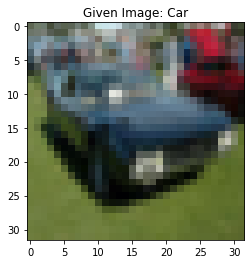

In [39]:
# Plotting a sample image

def plot_image(img, label):
    img = img / 2 + 0.5
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.title( "Given Image: " + classes[label.item()] )
    plt.show()

traindata_iter = iter(trainsetloader)
image, label = traindata_iter.next()
image_num = 10 #between 0-29

plot_image( torchvision.utils.make_grid(image[image_num]), label[image_num] )

### Define the Convolutional Neural Network:
**conv1:**
- Input: 3 channel image input of **32x32**
- Kernel size: **5x5**
- Output: 6 feature maps of **28x28**

**pool1:**
- Input: feature maps of **28x28**
- Kernel size: **2x2**
- Stride: **2**
- Output: 6 feature maps of **14x14**

**conv2:**
- Input: feature maps of **14x14**
- Kernel size: **5x5**
- Output: 16 feature maps of **10x10**

**pool2 (same as pool1, defined separately for clarity):**
- Input: feature maps of **10x10**
- Kernel size: **2x2**
- Stride: **2**
- Output: 16 feature maps of **5x5**

**flatten the previous layers output to tensor dimension (1, 16x5x5)**

**fc1, fc2, fc3:**
- Initial **16x5x5** nodes and ends with **10** nodes for 10 classes.

In [40]:
# Make the CNN:

class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(16*5*5, 150)
        self.fc2 = nn.Linear(150, 75)
        self.fc3 = nn.Linear(75, 10)
    
    def forward(self, inp):
        conv1_out = functional.relu( self.conv1(inp) )
        pool1_out = self.pool( conv1_out )
        
        conv2_out = functional.relu( self.conv2(pool1_out) )
        pool2_out = self.pool( conv2_out )
        
        # flatten:
        pool2_out = pool2_out.view(-1, 16*5*5)
        fc1_out = functional.relu( self.fc1( pool2_out ) )
        fc2_out = functional.relu( self.fc2(fc1_out) )
        fc3_out = self.fc3( fc2_out )
        
        return fc3_out

### Train the network:

In [41]:
network = CustomNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.1)

print("--------Training Start--------")
num_epochs = 20
training_losses = []

for epoch in range(1, num_epochs+1):
    current_loss = 0
    
    for i, batch in enumerate(trainsetloader):
        # get images and labels from single batch
        images, labels = batch
        
        # zero out the gradients at start of each batch
        optimizer.zero_grad()
        
        # make a prediction
        predictions = network(images)
        
        # calculate loss using criterion
        loss = criterion(predictions, labels)
        
        # calculate gradients
        loss.backward()
        
        # backpropogate update
        optimizer.step()
        
        # add up running loss for reporting after each epoch
        current_loss += loss.item()
        
    training_losses.append(current_loss)
    print("Epoch #", epoch, "\tRunning loss: ", current_loss/len(trainsetloader))

print("--------Training Done--------")

--------Training Start--------
Epoch # 1 	Running loss:  1.6944101159988796
Epoch # 2 	Running loss:  1.3529363557758916
Epoch # 3 	Running loss:  1.2180120818401856
Epoch # 4 	Running loss:  1.1205408480007204
Epoch # 5 	Running loss:  1.0512561143410013
Epoch # 6 	Running loss:  0.9961445871483586
Epoch # 7 	Running loss:  0.9529335524553872
Epoch # 8 	Running loss:  0.9143390433296302
Epoch # 9 	Running loss:  0.8876447116248823
Epoch # 10 	Running loss:  0.8543536099189044
Epoch # 11 	Running loss:  0.8367555944341775
Epoch # 12 	Running loss:  0.8105944022312805
Epoch # 13 	Running loss:  0.7982889628724988
Epoch # 14 	Running loss:  0.7820746709414421
Epoch # 15 	Running loss:  0.774639504304101
Epoch # 16 	Running loss:  0.7582309405980313
Epoch # 17 	Running loss:  0.7466537872419861
Epoch # 18 	Running loss:  0.7439753976798587
Epoch # 19 	Running loss:  0.7355368290840686
Epoch # 20 	Running loss:  0.7299505876758245
--------Training Done--------


### Plot the training loss curve:

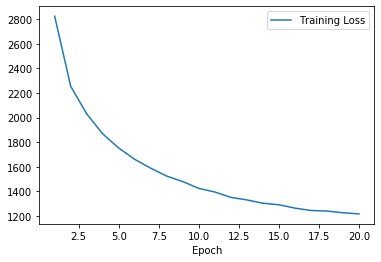

In [42]:
plt.plot(np.arange(1, num_epochs+1), training_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.legend(loc = "best")
plt.show()

### Save the model:

In [43]:
model_path = "./models/"
customnet_cnn_directory = "CustomNet/customnet_cifar10.pth"

In [45]:
torch.save( network.state_dict(), model_path + customnet_cnn_directory )

### Get saved model:

**Useful when resuming work in notebook. Network parameters can be loaded from file, training can be skipped.**

In [46]:
network = CustomNet()
network.load_state_dict( torch.load(model_path + customnet_cnn_directory) )

<All keys matched successfully>

### Test the model and get accuracy on test set:

In [47]:
with torch.no_grad():
    total_count = 0
    total_correct = 0
    i=0
    
    test_accuracy = []
    
    for i, batch in enumerate(testsetloader, 0):
        test_images, test_labels = batch
        
        predictions = network(test_images)
        value, predict = torch.max(predictions, 1)
        
        batch_count = test_labels.shape[0]
        batch_correct = (predict==test_labels).sum().item()
        total_count += batch_count
        total_correct += batch_correct
        
        print("\nBatch #", i)
        print("Predict: ", predict.numpy())
        print("Acctual: ", test_labels.numpy())
        print("Batch Accuracy: ", ((batch_correct*100)/batch_count))
        
        test_accuracy.append( ((total_correct*100)/total_count) )
    
    print("\nFinal accuracy: ", ((total_correct*100)/total_count))


Batch # 0
Predict:  [3 8 9 0 4 6 3 4 5 1 0 9 3 7 9 9 5 7 8 6 7 2 4 9 4 4 4 4 9 6]
Acctual:  [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6]
Batch Accuracy:  63.333333333333336

Batch # 1
Predict:  [3 3 4 3 3 3 4 1 9 5 4 6 7 6 0 9 3 3 7 6 7 9 6 5 8 8 7 5 5 4]
Acctual:  [6 5 4 5 9 2 4 1 9 5 4 6 5 6 0 9 3 9 7 6 9 8 0 3 8 8 7 7 4 6]
Batch Accuracy:  53.333333333333336

Batch # 2
Predict:  [7 3 6 1 4 6 1 4 3 7 2 3 0 8 1 2 7 3 3 8 8 8 1 7 2 7 2 0 9 9]
Acctual:  [7 3 6 3 6 2 1 2 3 7 2 6 8 8 0 2 9 3 3 8 8 1 1 7 2 5 2 7 8 9]
Batch Accuracy:  60.0

Batch # 3
Predict:  [0 3 8 6 4 5 6 8 0 3 5 3 6 7 1 1 2 6 8 5 4 1 2 2 9 4 0 1 3 3]
Acctual:  [0 3 8 6 4 6 6 0 0 7 4 5 6 3 1 1 3 6 8 7 4 0 6 2 1 3 0 4 2 7]
Batch Accuracy:  50.0

Batch # 4
Predict:  [0 7 1 2 8 9 0 3 3 3 4 1 1 9 1 4 9 7 6 8 3 5 6 3 8 7 6 6 6 5]
Acctual:  [8 3 1 2 8 0 8 3 5 2 4 1 8 9 1 2 9 7 2 9 6 5 6 3 8 7 6 2 5 2]
Batch Accuracy:  53.333333333333336

Batch # 5
Predict:  [8 1 6 3 2 5 4 9 3 4 2 1 6 6 8 2 8 4 7 0 5 9 1 8 9 9

Batch # 63
Predict:  [3 8 6 9 3 8 8 8 3 7 8 5 2 0 1 4 3 1 5 3 6 6 0 9 9 9 9 8 6 4]
Acctual:  [6 8 6 9 3 8 9 8 0 7 8 5 0 0 1 3 9 1 5 3 4 4 0 9 9 9 9 8 2 4]
Batch Accuracy:  70.0

Batch # 64
Predict:  [2 9 5 1 3 1 0 8 4 4 1 6 2 5 2 4 7 9 0 6 2 7 2 8 4 7 8 3 5 0]
Acctual:  [2 2 5 1 9 1 0 9 4 2 1 6 0 3 7 6 3 1 8 6 5 7 2 8 4 4 8 3 5 0]
Batch Accuracy:  56.666666666666664

Batch # 65
Predict:  [3 7 4 0 0 2 7 7 9 0 7 7 6 0 5 9 7 7 8 9 1 4 3 2 6 2 3 4 6 3]
Acctual:  [5 7 4 4 2 2 7 3 6 0 2 7 6 2 3 0 7 7 8 1 1 4 6 0 6 6 5 5 6 3]
Batch Accuracy:  50.0

Batch # 66
Predict:  [9 6 6 7 7 6 4 9 5 7 7 1 6 2 9 2 3 0 2 3 6 3 2 3 7 3 7 0 9 7]
Acctual:  [9 3 6 8 7 6 4 9 5 6 4 1 6 3 8 2 3 9 8 5 1 5 4 5 7 5 7 8 9 1]
Batch Accuracy:  46.666666666666664

Batch # 67
Predict:  [2 4 5 9 0 6 6 3 3 3 9 0 3 6 8 4 3 3 7 3 7 1 2 2 2 6 5 3 3 8]
Acctual:  [7 2 5 6 8 4 6 5 3 9 9 8 5 5 6 4 5 9 7 3 4 1 4 2 3 6 5 5 2 8]
Batch Accuracy:  40.0

Batch # 68
Predict:  [0 0 1 8 3 1 3 5 8 6 8 3 8 4 5 3 5 3 8 8 5 6 7 1 8 4 4 7 3 4]


Batch # 130
Predict:  [6 3 9 0 1 7 2 7 2 3 4 9 0 9 4 4 9 2 6 7 3 9 4 3 5 8 9 0 5 7]
Acctual:  [3 3 9 0 1 2 3 2 2 5 4 9 8 7 4 4 9 7 6 7 7 1 2 3 5 1 9 0 3 3]
Batch Accuracy:  53.333333333333336

Batch # 131
Predict:  [1 5 6 6 7 7 6 8 8 9 9 6 1 0 7 3 8 2 9 3 8 1 4 3 5 0 2 8 9 3]
Acctual:  [1 5 6 6 2 4 6 8 8 9 6 6 1 0 7 5 8 2 1 5 8 1 4 7 5 0 3 9 9 5]
Batch Accuracy:  66.66666666666667

Batch # 132
Predict:  [2 8 2 5 9 0 2 3 6 2 7 0 7 9 8 7 1 6 6 1 4 3 9 2 6 7 7 1 1 6]
Acctual:  [2 8 4 1 9 0 4 4 8 2 9 0 7 9 8 7 1 3 2 9 9 5 9 7 6 7 7 1 1 2]
Batch Accuracy:  56.666666666666664

Batch # 133
Predict:  [4 2 0 6 8 7 7 4 2 9 7 2 5 0 0 5 8 6 8 2 7 7 0 6 8 1 3 3 1 4]
Acctual:  [4 2 0 6 8 7 6 2 2 9 8 2 4 2 0 5 8 6 8 2 7 7 3 1 8 1 6 5 9 7]
Batch Accuracy:  63.333333333333336

Batch # 134
Predict:  [8 9 6 5 8 4 9 4 0 6 1 4 3 6 6 2 0 0 9 7 8 7 7 4 6 7 7 4 5 4]
Acctual:  [8 9 6 4 8 1 9 4 0 4 1 4 3 6 2 2 7 0 0 7 0 7 4 3 6 7 7 4 5 4]
Batch Accuracy:  70.0

Batch # 135
Predict:  [3 3 4 4 0 4 0 7 6 9 6 5 0 

Batch # 193
Predict:  [9 9 4 9 1 7 5 2 0 1 2 9 6 9 0 1 0 6 5 3 5 5 4 4 3 3 5 3 7 2]
Acctual:  [9 8 2 8 7 7 5 5 0 1 2 9 6 1 0 1 0 6 5 0 5 7 4 4 8 3 5 3 7 2]
Batch Accuracy:  70.0

Batch # 194
Predict:  [3 2 6 5 7 6 7 2 5 4 6 2 5 5 5 3 9 5 2 3 2 4 7 6 2 7 5 8 5 3]
Acctual:  [5 8 3 5 7 3 7 0 5 4 5 6 9 3 5 3 8 2 4 2 2 6 7 6 0 5 5 8 4 5]
Batch Accuracy:  40.0

Batch # 195
Predict:  [2 1 3 5 4 5 2 0 7 2 8 1 5 4 9 6 4 7 9 5 7 3 4 4 4 1 6 9 4 8]
Acctual:  [6 1 3 5 4 7 3 0 7 2 0 1 2 4 9 6 4 5 9 7 7 6 7 4 3 1 6 9 4 8]
Batch Accuracy:  66.66666666666667

Batch # 196
Predict:  [0 3 4 4 3 4 3 1 4 6 4 0 0 0 7 6 9 4 8 1 8 6 9 2 7 1 4 6 2 1]
Acctual:  [0 3 1 6 4 4 2 1 4 6 3 0 8 9 7 6 8 4 8 1 4 5 9 4 7 1 4 5 3 1]
Batch Accuracy:  56.666666666666664

Batch # 197
Predict:  [4 6 9 7 8 3 9 2 1 0 8 7 2 1 7 5 4 6 7 7 4 4 6 4 7 6 6 1 9 1]
Acctual:  [2 6 4 7 1 5 9 3 1 4 8 7 7 0 4 3 4 6 7 7 5 4 4 4 3 6 6 1 9 9]
Batch Accuracy:  53.333333333333336

Batch # 198
Predict:  [2 3 4 5 2 7 8 5 0 6 1 0 9 7 1 6 4 3 9 8 6

Batch # 250
Predict:  [6 9 8 8 4 7 3 7 4 4 8 2 9 0 7 8 1 6 3 8 4 2 9 5 4 8 9 3 3 5]
Acctual:  [6 9 8 8 6 7 4 7 2 3 8 0 9 0 7 8 1 2 3 2 4 2 9 0 3 8 9 6 5 5]
Batch Accuracy:  63.333333333333336

Batch # 251
Predict:  [2 3 1 0 6 1 3 4 5 2 5 0 8 9 0 4 7 9 6 5 4 6 0 8 4 1 2 7 7 1]
Acctual:  [2 4 1 0 6 1 8 4 5 5 5 0 8 9 0 5 7 9 6 3 4 6 4 9 7 1 2 5 2 8]
Batch Accuracy:  63.333333333333336

Batch # 252
Predict:  [3 4 9 9 8 1 7 7 5 4 1 4 1 9 3 8 8 1 1 3 0 9 2 1 1 6 2 7 2 6]
Acctual:  [0 2 2 9 8 1 9 7 7 3 1 4 1 1 3 8 8 1 9 3 8 9 5 1 1 6 2 7 2 6]
Batch Accuracy:  66.66666666666667

Batch # 253
Predict:  [4 6 9 6 0 1 3 9 3 3 2 8 2 9 1 4 6 8 7 9 7 7 7 9 4 5 0 0 3 3]
Acctual:  [2 6 9 6 0 1 3 9 3 8 8 8 2 9 1 2 6 0 5 0 7 7 7 9 4 5 0 2 3 5]
Batch Accuracy:  70.0

Batch # 254
Predict:  [5 8 9 9 2 2 1 3 4 2 9 1 4 7 1 9 3 8 8 9 9 6 9 8 5 4 6 6 9 6]
Acctual:  [5 8 9 1 2 7 1 3 4 6 9 1 0 7 1 9 5 8 1 9 9 7 9 8 3 0 2 6 0 2]
Batch Accuracy:  60.0

Batch # 255
Predict:  [2 4 0 8 4 8 1 7 7 2 7 9 3 6 2 9 4 6 5 4 2

Batch # 303
Predict:  [6 7 6 3 2 7 9 0 5 9 3 8 7 2 4 0 6 7 2 3 1 0 4 1 8 8 4 9 4 4]
Acctual:  [2 7 6 3 2 5 9 0 5 9 9 8 7 7 4 8 6 5 2 3 1 0 4 1 8 8 4 9 4 4]
Batch Accuracy:  80.0

Batch # 304
Predict:  [5 3 4 2 0 1 9 8 3 4 8 3 6 4 5 7 6 4 5 6 9 3 3 2 0 1 5 9 5 9]
Acctual:  [3 3 9 2 0 1 1 8 4 4 8 3 2 9 5 7 6 2 5 4 7 3 3 9 0 1 5 9 3 7]
Batch Accuracy:  60.0

Batch # 305
Predict:  [6 7 4 2 2 5 6 3 8 9 3 6 0 3 3 0 3 7 2 8 9 2 0 4 9 8 8 9 1 1]
Acctual:  [6 0 4 2 2 5 6 3 8 9 5 6 1 4 5 4 6 7 2 1 0 2 0 4 9 8 8 9 1 1]
Batch Accuracy:  70.0

Batch # 306
Predict:  [5 0 0 8 4 2 4 4 5 4 3 3 2 8 6 6 0 1 1 9 8 3 7 8 9 4 0 9 8 9]
Acctual:  [5 0 0 8 7 1 7 4 5 4 3 3 2 0 6 6 0 1 3 9 8 3 7 8 9 4 8 9 0 9]
Batch Accuracy:  76.66666666666667

Batch # 307
Predict:  [7 1 6 2 9 5 6 9 4 9 8 7 7 9 4 6 2 9 6 6 8 2 1 8 2 3 9 2 9 8]
Acctual:  [7 1 6 2 9 5 6 9 3 9 8 7 7 1 6 5 3 1 3 1 2 7 1 8 2 0 9 7 9 8]
Batch Accuracy:  60.0

Batch # 308
Predict:  [8 6 7 3 7 1 3 9 4 9 5 6 6 1 5 8 0 4 9 7 3 5 3 3 5 1 8 7 2 3]
Acctual:

### Plot of how the test accuracy varies over test batches:

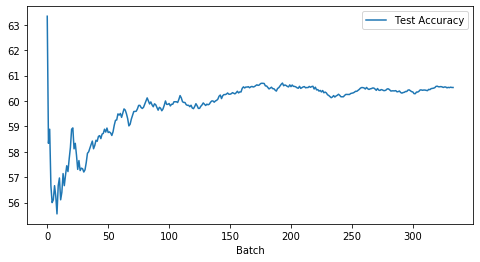

In [48]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(0, i+1), test_accuracy, label="Test Accuracy")
plt.xlabel("Batch")
plt.legend(loc = "best")
plt.show()

### Sample plot of a test image aloing with network's prediction:

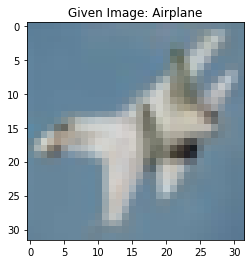

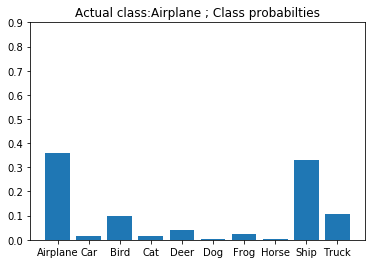

In [50]:
with torch.no_grad():
    testsetiter = iter(testsetloader)
    test_images, test_labels = next(testsetiter)
    
    # can be anything between 0-29 (a batch is of 30 images)
    image_id = 10
    
    # plot test image
    plot_image( torchvision.utils.make_grid(test_images[image_id]), test_labels[image_id] )
    
    # bar plot result probabilities
    predictions = network(test_images)
    log_softmax_out = functional.log_softmax(predictions, dim = 1)
    probabilities = torch.exp(log_softmax_out)
    probs = probabilities.numpy()[image_id]
    
    plt.bar(classes, probs)
    plt.title("Actual class:" + classes[test_labels[image_id]] + " ; Class probabilties")
    plt.yticks( (np.arange(0, 1, step = 0.1)) )
    plt.show()